In [ ]:
# 1. Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Installation des bibliothèques nécessaires**
Cette commande installe les bibliothèques Python indispensables pour notre projet :



*   **wfdb**: pour lire et manipuler les fichiers de données ECG

*  **neurokit2**: pour le traitement et l’analyse des signaux physiologiques, notamment ECG.
*   **matplotlib** : pour tracer des graphiques et visualiser les données.


*   **numpy** : pour manipuler efficacement les tableaux et calculs numériques.

*   **scipy** : pour les fonctions scientifiques avancées, notamment le traitement du signal.

Elle s’exécute dans l’environnement Python (notebook ou console) avec la commande pip (gestionnaire de paquets).

In [ ]:
!pip install wfdb neurokit2 matplotlib numpy scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 84.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


**Traitement et segmentation des signaux ECG à partir de plusieurs bases de données**

Ce script permet de charger, segmenter, et fusionner deux datasets ECG (ECG-ID et PTB) pour préparer des données d’entraînement ou d’analyse.




**Détail des étapes :**


1.   **Définition des paramètres**


*  SEGMENT_DURATION : durée d’un segment ECG en secondes (ici 5 secondes).
*  SAMPLE_RATE : fréquence d’échantillonnage des signaux ECG (1000 Hz).



2.   **Fonction segment_signal**


Cette fonction découpe un signal ECG continu en segments de longueur fixe (5 secondes ici).
Chaque segment est une portion du signal qui sera utilisée individuellement pour l’analyse ou l’entraînement.



3.   **Fonction process_dataset**


*   Parcourt les dossiers d’un dataset donné, chaque dossier correspondant à un patient.
*  Pour chaque patient, charge tous les enregistrements ECG (.dat).


*   Segmente chaque enregistrement en plusieurs segments de 5 secondes.
*  Associe à chaque segment un label correspondant à l’ID du patient.


*   Gère les erreurs de lecture et affiche un rapport d’avancement.

4.   **Chargement des datasets ECG-ID et PTB**


*   On traite d’abord ECG-ID, en commençant les IDs patients à 0.


*  Ensuite, on traite PTB, en continuant les IDs à partir de la fin d’ECG-ID pour éviter les doublons.
*  On fusionne les segments et labels des deux datasets en une seule liste.



5.   **Conversion en arrays NumPy**

Pour faciliter les traitements ultérieurs (ex : entraînement de modèles), on convertit les listes en arrays NumPy.


6.   **Sauvegarde**

Le dataset combiné est sauvegardé dans un fichier compressé .npz pour un chargement rapide et pratique lors des prochaines utilisations.





In [ ]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Paramètres généraux
SEGMENT_DURATION = 5  # secondes
SAMPLE_RATE = 1000    # Hz (adapter si nécessaire)

# Chemins datasets
path_ecg_id = "/content/drive/MyDrive/CAREDIFAY Stage/ecg-id-database-1.0.0"
path_ptb = "/content/drive/MyDrive/CAREDIFAY Stage/ptb-diagnostic-ecg-database-1.0.0/ptb-diagnostic-ecg-database-1.0.0"

def segment_signal(signal, segment_duration, fs):
    segment_length = segment_duration * fs
    segments = []
    for start in range(0, len(signal), segment_length):
        end = start + segment_length
        if end <= len(signal):
            segments.append(signal[start:end])
    return np.array(segments)

def process_dataset(dataset_path, starting_patient_id=0):
    all_segments = []
    all_labels = []
    patient_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    print(f"Dataset {dataset_path} : {len(patient_folders)} patients trouvés")

    for i, patient_folder in enumerate(patient_folders):
        patient_id = starting_patient_id + i
        folder_path = os.path.join(dataset_path, patient_folder)

        records = [f.split('.')[0] for f in os.listdir(folder_path) if f.endswith('.dat')]
        records = list(set(records))

        print(f"Patient {patient_id} ({patient_folder}): {len(records)} enregistrements")

        for rec in records:
            record_path = os.path.join(folder_path, rec)
            try:
                record = wfdb.rdrecord(record_path)
                signal = record.p_signal[:, 0]  # Lead 0
                segments = segment_signal(signal, SEGMENT_DURATION, SAMPLE_RATE)
                all_segments.extend(segments)
                all_labels.extend([patient_id] * len(segments))
            except Exception as e:
                print(f"Erreur lecture {record_path} : {e}")
    return all_segments, all_labels, patient_id + 1

# Traiter d'abord ECG-ID dataset
segments_ecg_id, labels_ecg_id, next_patient_id = process_dataset(path_ecg_id, starting_patient_id=0)

# Puis traiter PTB dataset (les IDs commencent après ECG-ID)
segments_ptb, labels_ptb, _ = process_dataset(path_ptb, starting_patient_id=next_patient_id)

# Fusionner les deux datasets
all_segments = segments_ecg_id + segments_ptb
all_labels = labels_ecg_id + labels_ptb

print(f"Total segments combinés : {len(all_segments)}")
print(f"Total labels combinés : {len(all_labels)}")

# Convertir en numpy arrays pour la suite
all_segments_np = np.array(all_segments)
all_labels_np = np.array(all_labels)

print(f"Shape des segments : {all_segments_np.shape}")
print(f"Shape des labels : {all_labels_np.shape}")

# Sauvegarder pour usage futur
np.savez("combined_ecg_segments_labels.npz", segments=all_segments_np, labels=all_labels_np)


Dataset /content/drive/MyDrive/CAREDIFAY Stage/ecg-id-database-1.0.0 : 92 patients trouvés
Patient 0 (Person_87): 2 enregistrements
Patient 1 (Person_83): 2 enregistrements
Patient 2 (Person_89): 2 enregistrements
Patient 3 (Person_86): 2 enregistrements
Patient 4 (Person_88): 3 enregistrements
Patient 5 (Person_85): 3 enregistrements
Patient 6 (Person_90): 2 enregistrements
Patient 7 (Person_82): 2 enregistrements
Patient 8 (Person_84): 2 enregistrements
Patient 9 (Person_81): 2 enregistrements
Patient 10 (Person_71): 5 enregistrements
Patient 11 (Person_72): 8 enregistrements
Patient 12 (Person_79): 2 enregistrements
Patient 13 (Person_76): 3 enregistrements
Patient 14 (Person_75): 3 enregistrements
Patient 15 (Person_80): 2 enregistrements
Patient 16 (Person_74): 1 enregistrements
Patient 17 (Person_77): 3 enregistrements
Patient 18 (Person_78): 2 enregistrements
Patient 19 (Person_73): 2 enregistrements
Patient 20 (Person_66): 2 enregistrements
Patient 21 (Person_62): 3 enregistrem

**Prétraitement des segments ECG**

Ce code réalise le nettoyage et la normalisation des segments ECG pour préparer les données en vue d’un traitement par un modèle d’apprentissage automatique (par exemple un CNN 1D).

**Étapes réalisées :**


1.   **Nettoyage du signal avec NeuroKit2**


*  La fonction nk.ecg_clean applique un filtrage passe-bande adapté au signal ECG afin d’éliminer le bruit et les artefacts.
*   Cela permet d’obtenir un signal plus net et exploitable pour les analyses.


2.  **Normalisation**


*  Chaque segment est normalisé pour que ses valeurs soient comprises entre 0 et 1.
*   Cela évite que l’amplitude absolue influence le modèle et facilite la convergence lors de l’entraînement.


3.  **Structuration des données**


*   Les segments nettoyés sont convertis en un tableau NumPy pour une manipulation efficace.
*  Une dimension supplémentaire est ajoutée à la fin (np.newaxis) pour représenter le canal unique du signal, format attendu par les modèles CNN 1D.








In [ ]:
import neurokit2 as nk

def preprocess_segments(segments, sample_rate=1000):
    cleaned_segments = []
    for seg in segments:
        # Nettoyer le signal (filtrage passe-bande)
        cleaned = nk.ecg_clean(seg, sampling_rate=sample_rate)
        # Normaliser (centrer et réduire entre 0 et 1)
        cleaned = (cleaned - np.min(cleaned)) / (np.max(cleaned) - np.min(cleaned))
        cleaned_segments.append(cleaned)
    return np.array(cleaned_segments)

# Appliquer sur l’ensemble des segments
cleaned_segments_np = preprocess_segments(all_segments_np, SAMPLE_RATE)

print("Shape après nettoyage :", cleaned_segments_np.shape)

# Ajouter la dimension canal (pour CNN 1D)
cleaned_segments_np = cleaned_segments_np[..., np.newaxis]
print("Shape finale (batch, longueur, canal) :", cleaned_segments_np.shape)


Shape après nettoyage : (10174, 5000)
Shape finale (batch, longueur, canal) : (10174, 5000, 1)


**Visualisation et statistiques des segments ECG bruts**

Ce bloc de code permet d'explorer visuellement et numériquement les segments ECG extraits avant tout prétraitement :


1.   **Affichage graphique**


*   Les trois premiers segments ECG sont tracés avec matplotlib pour observer directement la forme du signal brut.
*   Chaque graphique affiche également le label (identifiant du patient) associé à ce segment.


2.   **Statistiques simples**


*   Pour ces mêmes segments, on calcule et affiche des statistiques basiques :

  *   Valeur minimale
  *   Valeur maximale

  *   Moyenne
*   Ces informations aident à comprendre l’échelle et la variation des signaux ECG d’origine, avant nettoyage ou normalisation.




Cette étape d’analyse exploratoire est importante pour valider la qualité et la cohérence des données brutes avant de lancer les étapes d’entraînement ou de traitement avancé.






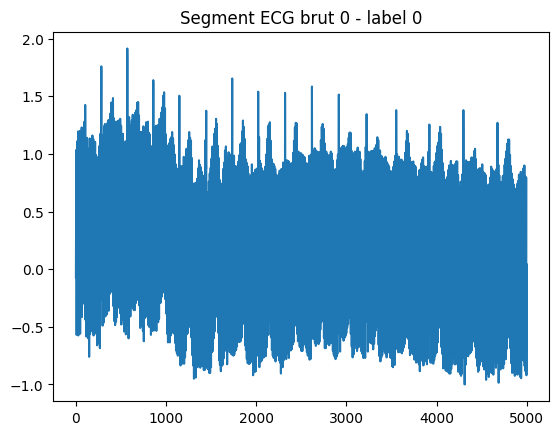

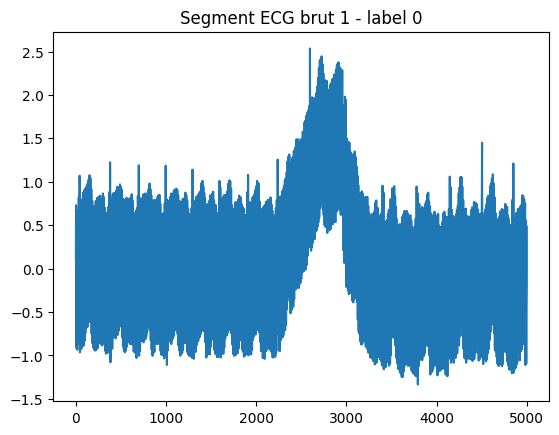

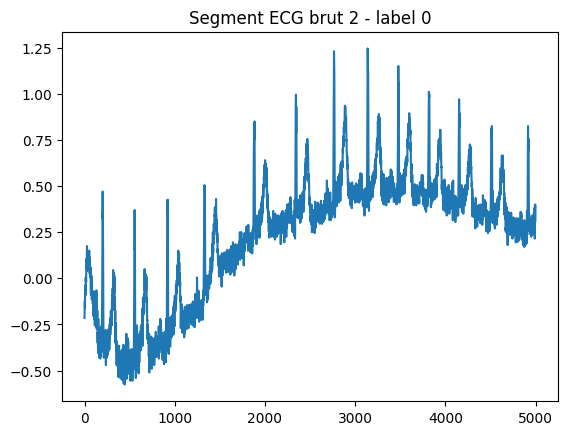

Segment 0 stats: min=-1.000, max=1.915, mean=0.200
Segment 1 stats: min=-1.335, max=2.535, mean=0.102
Segment 2 stats: min=-0.575, max=1.245, mean=0.230


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Affiche quelques segments ECG bruts
for i in range(3):
    plt.plot(all_segments_np[i])
    plt.title(f"Segment ECG brut {i} - label {all_labels_np[i]}")
    plt.show()

# Vérifie les stats simples (min, max, mean) des premiers segments
for i in range(3):
    print(f"Segment {i} stats: min={np.min(all_segments_np[i]):.3f}, max={np.max(all_segments_np[i]):.3f}, mean={np.mean(all_segments_np[i]):.3f}")


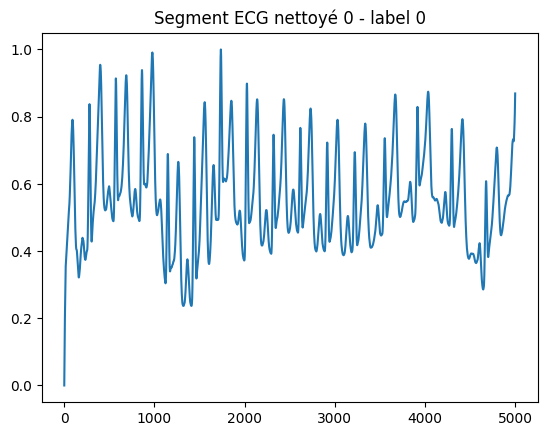

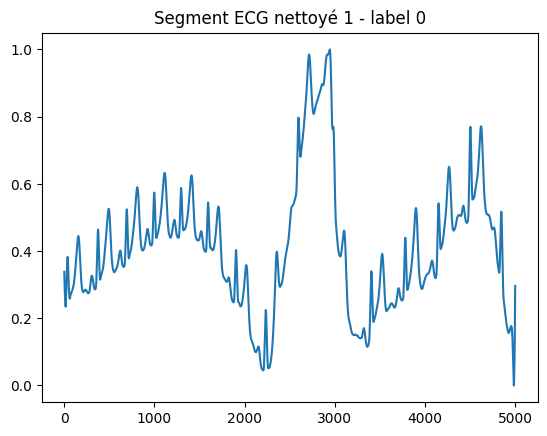

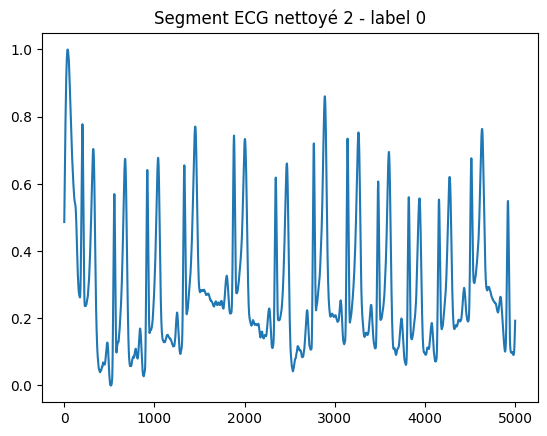

Segment nettoyé 0 stats: min=0.000, max=1.000, mean=0.553
Segment nettoyé 1 stats: min=0.000, max=1.000, mean=0.412
Segment nettoyé 2 stats: min=0.000, max=1.000, mean=0.287


In [ ]:
for i in range(3):
    plt.plot(cleaned_segments_np[i].squeeze())
    plt.title(f"Segment ECG nettoyé {i} - label {all_labels_np[i]}")
    plt.show()

for i in range(3):
    print(f"Segment nettoyé {i} stats: min={np.min(cleaned_segments_np[i]):.3f}, max={np.max(cleaned_segments_np[i]):.3f}, mean={np.mean(cleaned_segments_np[i]):.3f}")


**Division des données en ensembles d'entraînement et de test**

Ce bloc utilise la fonction train_test_split de scikit-learn pour séparer les données en deux parties :


*  **Ensemble d'entraînement (80%) :**
Sert à entraîner le modèle sur la majorité des segments ECG nettoyés.


*   **Ensemble de test (20%) :**
Permet d’évaluer la performance du modèle sur des données qu’il n’a jamais vues.





In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    cleaned_segments_np, all_labels_np, test_size=0.2, random_state=42, stratify=all_labels_np)

print(f"Train samples : {X_train.shape[0]}, Test samples : {X_test.shape[0]}")



Train samples : 8139, Test samples : 2035


**Construction d'un réseau de type Siamese simple pour l'ECG**


1.  **Définition du réseau de base** (base_network_simple) :


*   C’est un modèle convolutionnel 1D simple qui prend en entrée un segment ECG (forme (5000, 1)).
*  Il comprend deux couches Conv1D avec activation ReLU, chacune suivie d’un MaxPooling1D pour réduire la dimension temporelle.
*  Ensuite, une couche Flatten aplatit la sortie avant une couche dense finale à 16 neurones, qui produit un vecteur d’embedding (représentation compacte du segment ECG).

2.   **Test rapide du modèle :**

*  On crée un exemple aléatoire de segment pour vérifier que le modèle génère bien un embedding de taille 16.



3.  **Fonctions spécifiques au réseau Siamese :**


*   contrastive_loss : fonction de perte qui encourage les embeddings des paires similaires à être proches, et ceux des paires différentes à être éloignés par au moins une marge donnée.
*   euclidean_distance : calcule la distance euclidienne entre deux embeddings.
4.   **Construction du réseau Siamese complet :**


*   Deux entrées sont définies (input_a et input_b), chacune représentant un segment ECG.

*  Chaque entrée passe par le même réseau base_network_simple (partage des poids).
*  La distance entre les deux embeddings est calculée avec Lambda(euclidean_distance).




5.   **Fonction de métrique compute_accuracy :**


*   Permet d’évaluer la performance en décidant que si la distance est inférieure à 0.5, les segments appartiennent à la même personne, sinon non.

*  Retourne la moyenne des prédictions correctes.











In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Lambda, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
#input_shape = X_train.shape[1:]  # Par exemple (100, 1)
input_shape = (5000, 1)


def create_base_network_simple(input_shape):
    input = Input(shape=input_shape)
    x = Conv1D(16, 3, activation='relu')(input)
    x = MaxPooling1D(2)(x)
    x = Conv1D(32, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    return Model(input, x)

base_network_simple = create_base_network_simple(input_shape)
base_network_simple.summary()

test_embedding = base_network_simple.predict(np.random.rand(1, input_shape[0], input_shape[1]))
print("Embedding simple test:", test_embedding)



def contrastive_loss(y_true, y_pred, margin=1):
    '''Fonction perte pour réseau Siamese'''
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True) + K.epsilon())


input_shape = X_train.shape[1:]  # Exemple: (longueur_segment, 1)


input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processed_a = base_network_simple(input_a)
processed_b = base_network_simple(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])
def compute_accuracy(y_true, y_pred):
    '''Métrique binaire : distance < 0.5 → même personne'''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 4998, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2499, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2497, 32)       │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1248, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 39936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       638,992 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,624 (2.44 MB)

 Trainable params: 640,624 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Embedding simple test: [[0.0000000e+00 5.8231406e-02 0.0000000e+00 2.0707925e-01 3.1269556e-01
  1.5420553e-01 6.6423342e-02 0.0000000e+00 3.6479571e-01 2.2502142e-01
  0.0000000e+00 4.2328659e-01 0.0000000e+00 0.0000000e+00 7.7709556e-05
  4.9370371e-02]]


**Générateur personnalisé de paires pour l'entraînement d'un réseau Siamese ECG**

**Classe ECGPairGenerator :**
Cette classe hérite de tf.keras.utils.Sequence et génère par lot (batch) des paires d’échantillons ECG pour entraîner un réseau Siamese.


1.    **Initialisation (__init__) :**

*   Prend en entrée les données X (segments ECG), les labels y, la taille de batch, et un indicateur de mélange (shuffle).
*   Crée un dictionnaire label_to_indices pour retrouver rapidement les indices des segments appartenant à chaque classe (patient).

*   Filtre les classes ne contenant pas au moins deux segments, car pour créer des paires positives, il faut au moins deux échantillons.

2.   **Longueur du générateur (__len__) :**


*   Définit le nombre de lots par époque en fonction de la taille du dataset et la taille de batch.

3.   **Récupération d’un lot (__getitem__) :**


*   Pour chaque batch, crée deux tableaux pour contenir les deux ensembles de segments ECG (les deux entrées du réseau Siamese).

*   Pour chaque élément du batch, choisit aléatoirement si la paire est positive (même personne) ou négative (personnes différentes).
*   Si positive : choisit une classe valide, puis deux indices distincts appartenant à cette classe.

*  Si négative : choisit deux classes différentes et un indice aléatoire dans chacune.
*   Remplit les tableaux avec les segments ECG correspondants et met à jour les labels cibles (1 pour même personne, 0 pour différente).

4.   **Fin d’époque (on_epoch_end) :**


*  Si shuffle est activé, mélange les données pour chaque nouvelle époque.
*  Met à jour les indices des labels valides en fonction du nouvel ordre.








In [ ]:
class ECGPairGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.labels_set = list(set(y))
        self.label_to_indices = {
            label: np.where(y == label)[0] for label in self.labels_set
        }

        # Filtrer les classes avec au moins 2 échantillons
        self.valid_labels = [label for label, idxs in self.label_to_indices.items() if len(idxs) >= 2]

    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        pairs = [np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2])) for _ in range(2)]
        targets = np.zeros((self.batch_size, 1))

        for i in range(self.batch_size):
            if random.choice([True, False]):
                label = random.choice(self.valid_labels)  # 👈 utiliser valid_labels ici
                idx1, idx2 = random.sample(list(self.label_to_indices[label]), 2)
                targets[i] = 1
            else:
                label1, label2 = random.sample(self.labels_set, 2)
                idx1 = random.choice(self.label_to_indices[label1])
                idx2 = random.choice(self.label_to_indices[label2])
                targets[i] = 0

            pairs[0][i, :, :] = self.X[idx1]
            pairs[1][i, :, :] = self.X[idx2]

        return (pairs[0], pairs[1]), targets

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.X))
            np.random.shuffle(indices)
            self.X = self.X[indices]
            self.y = self.y[indices]
            self.label_to_indices = {
                label: np.where(self.y == label)[0] for label in self.labels_set
            }
            self.valid_labels = [label for label, idxs in self.label_to_indices.items() if len(idxs) >= 2]


**Création des générateurs de données pour l'entraînement et la validation**


*   **train_gen :** Ce générateur crée des lots (batchs) de paires d'échantillons ECG à partir des données d'entraînement X_train et des labels y_train. Chaque batch contient 32 paires. Il est utilisé pour alimenter le modèle pendant la phase d'entraînement.
*   **val_gen :** Ce générateur fonctionne de la même manière que train_gen, mais il utilise les données de test X_test et les labels y_test. Il est utilisé pour évaluer la performance du modèle sur des données qu'il n'a pas vues pendant l'entraînement.

Ces générateurs facilitent la création dynamique des paires positives et négatives nécessaires pour entraîner un réseau Siamese, tout en gérant efficacement la mémoire grâce au traitement par lots.



In [ ]:
train_gen = ECGPairGenerator(X_train, y_train, batch_size=32)
val_gen = ECGPairGenerator(X_test, y_test, batch_size=32)


**Création et entraînement du modèle Siamese**


*   **Définition des entrées :** Le modèle prend deux entrées input_a et input_b, chacune représentant un segment ECG avec la forme définie par input_shape (par exemple, 5000 points avec 1 canal).

*   **Extraction des embeddings :** Chaque entrée est passée dans le même réseau de base (base_network_simple) pour extraire un vecteur d'embedding (représentation compacte).

*   **Calcul de la distance :** La distance euclidienne entre les deux embeddings est calculée via une couche Lambda. Cette distance représente la similarité entre les deux segments ECG.
*  **Compilation du modèle :** Le modèle est compilé avec une fonction de perte contrastive adaptée aux réseaux Siamese, un optimiseur Adam, et une métrique personnalisée compute_accuracy qui mesure la précision selon un seuil sur la distance.

*  **Entraînement :** Le modèle est entraîné avec les générateurs train_gen et val_gen pendant 50 époques. Cela signifie que le réseau apprend à distinguer si deux segments ECG appartiennent à la même personne ou non, en utilisant des paires positives et négatives fournies par les générateurs.

Ce processus permet de construire un système de reconnaissance basé sur les caractéristiques ECG, capable de comparer efficacement deux signaux.



In [ ]:
import random
input_shape = X_train.shape[1:]  # (longueur_segment, 1)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network_simple(input_a)
processed_b = base_network_simple(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[compute_accuracy])

history = model.fit(train_gen, validation_data=val_gen, epochs=50)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - compute_accuracy: 0.6713 - loss: 0.2715 - val_compute_accuracy: 0.7004 - val_loss: 0.2288
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - compute_accuracy: 0.6899 - loss: 0.2301 - val_compute_accuracy: 0.7009 - val_loss: 0.2126
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - compute_accuracy: 0.7010 - loss: 0.2231 - val_compute_accuracy: 0.7202 - val_loss: 0.2168
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - compute_accuracy: 0.7068 - loss: 0.2231 - val_compute_accuracy: 0.6964 - val_loss: 0.2172
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - compute_accuracy: 0.7085 - loss: 0.2201 - val_compute_accuracy: 0.7282 - val_loss: 0.2235
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - compute_accuracy: 0.7205 - loss: 0.2075 - val_compute_accuracy: 0.7247 - val_loss: 0.2148
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - compute_accuracy: 0.7169 - loss: 0.2096 - val_compute_accuracy: 0.72

In [ ]:
# Sauvegarde du modèle Siamese complet
#model.save("siamese_model.h5")

# Sauvegarde du réseau de base (celui qui produit l'embedding)
base_network_simple.save("base_network_simple.h5")




*   Cette ligne sauvegarde **le modèle de réseau de base simple** (qui extrait les embeddings des segments ECG) dans un fichier .h5 au chemin indiqué.

*   Ce modèle est uniquement la partie du réseau qui transforme un segment ECG en un vecteur de caractéristiques (embedding).

* Cette sauvegarde permet de réutiliser ce modèle plus tard, sans avoir à le reconstruire ou à le réentraîner.
*   Élément de liste


*   Ici, on ne sauvegarde pas le modèle complet Siamese (qui compare deux segments), mais juste le réseau qui produit les embeddings.


*   Cela facilite par exemple l’extraction d’embeddings pour de nouvelles données.



**Tableau comparatif : Modèle de base simple vs Modèle Siamese**

| Aspect                  | Modèle Base Simple (`base_network_simple`)                   | Modèle Siamese (réseau complet)                                                              |
| ----------------------- | ------------------------------------------------------------ | -------------------------------------------------------------------------------------------- |
| **Fonction**            | Extrait un vecteur d'embedding à partir d'un segment ECG     | Compare deux embeddings pour estimer si deux segments appartiennent à la même personne       |
| **Entrées**             | Un segment ECG                                               | Deux segments ECG (deux entrées distinctes)                                                  |
| **Sortie**              | Un vecteur de caractéristiques (embedding)                   | Une distance entre deux embeddings (indiquant similarité)                                    |
| **Utilisation typique** | Extraction d’embeddings pour stockage ou classification      | Apprentissage de la similarité/différence entre paires                                       |
| **Sauvegarde**          | Sauvegardé seul dans un fichier `.h5`                        | Modèle complet sauvegardé, nécessite souvent des fonctions personnalisées (loss, distance)   |
| **Chargement**          | Simple, sans besoin de fonctions personnalisées              | Nécessite souvent `custom_objects` pour fonctions personnalisées (ex : `euclidean_distance`) |
| **Entraînement**        | Parfois utilisé pour pré-entrainer l’extracteur d’embeddings | Entraîné avec paires de données et fonction perte contrastive                                |
| **Complexité**          | Moins complexe, plus facile à manipuler                      | Plus complexe, implémentation et gestion plus technique                                      |


**Pourquoi créer un modèle Siamese si on utilise finalement seulement le modèle de base (base_network_simple) ?**


1.  **Rôle du modèle Siamese:**
Le modèle Siamese est conçu pour apprendre à comparer deux entrées (ici, deux segments ECG) et déterminer s’ils appartiennent à la même personne ou non.
Pour cela, il utilise deux fois le modèle de base (le même réseau partagé) pour extraire les embeddings, puis calcule une distance entre ces embeddings.

2.   **Pourquoi créer le modèle Siamese ?:**


*  **Pour l’entraînement** : Le réseau Siamese s’entraîne avec des paires d’échantillons et une fonction de perte adaptée (ex : perte contrastive) pour apprendre à bien séparer les embeddings des différentes personnes.
*   C’est donc pendant l’entraînement qu’on a besoin du modèle Siamese complet.



3.   **Pourquoi n’utiliser que le modèle de base ensuite ?:**


*   Une fois que le modèle Siamese est entraîné, la partie essentielle pour l’inférence est uniquement le **modèle de base**, car c’est lui qui calcule les embeddings.

*   Pour authentifier une nouvelle donnée, on n’a plus besoin de comparer deux segments simultanément avec le modèle Siamese complet, on extrait simplement l’embedding du segment avec le modèle de base, puis on compare cet embedding aux embeddings de référence (ex : par calcul de distance euclidienne).
*   Cela simplifie énormément l’utilisation, car tu manipules un seul segment à la fois et fais la comparaison à part (hors du modèle).

| Étape                      | Utilisation                            | Pourquoi ?                                                               |
| -------------------------- | -------------------------------------- | ------------------------------------------------------------------------ |
| **Entraînement**           | Modèle Siamese complet                 | Apprendre la fonction de similarité entre paires d’ECG                   |
| **Extraction & Inférence** | Modèle de base (`base_network_simple`) | Extraire les embeddings d’un segment individuel pour comparaison externe |








In [ ]:
base_network_simple.save("/content/drive/MyDrive/CAREDIFAY Stage/base_network_simple.h5")


In [ ]:
!pip install deepface


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.7/127.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.9/288.9 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=f3a6d4eb20599813c60d5a7f94e160c9d7c19d9c7cf83da7969061b9945dc3d7
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Success

In [ ]:
import os
import cv2
import numpy as np
import neurokit2 as nk
import wfdb
from deepface import DeepFace
from tensorflow.keras.models import load_model
from scipy.spatial.distance import cosine
from tqdm import tqdm

25-08-03 20:31:58 - Directory /root/.deepface has been created
25-08-03 20:31:58 - Directory /root/.deepface/weights has been created


In [ ]:
# --- Paramètres globaux ---
SAMPLE_RATE = 1000
FACE_THRESHOLD = 0.4
ECG_THRESHOLD = 0.2

#BASE_FOLDER = "utilisateurs"  # dossier racine pour tous les utilisateurs
BASE_FOLDER = "/content/drive/MyDrive/CAREDIFAY Stage/utilisateurs"  # dossier racine pour tous les utilisateurs
MODEL_PATH = "base_network_simple.h5"  # modèle tensorflow pour ECG

In [ ]:
import os
os.makedirs(BASE_FOLDER, exist_ok=True)


**Fonctions d’augmentation d’images:**

Ce bloc contient deux fonctions qui permettent d’augmenter artificiellement les données d’images utilisateur en créant des versions tournées (rotated) des images originales. Cette technique d’augmentation de données est importante pour améliorer la robustesse du modèle en augmentant la diversité des images d’entraînement.


*   rotate_image(image, angle) :
Cette fonction prend en entrée une image et un angle (en degrés), et retourne une nouvelle image qui est la version de l’originale pivotée autour de son centre selon cet angle.
   *   Utilisation de cv2.getRotationMatrix2D pour calculer la matrice de transformation de rotation.
   *   cv2.warpAffine applique cette transformation à l’image en conservant la taille originale.


*  augment_user_images(user_images_folder, rotation_step=25) :
Cette fonction réalise l’augmentation des images dans un dossier utilisateur donné :

  *   Elle liste toutes les images avec extensions .jpg, .jpeg ou .png.
  *   Pour chaque image, elle génère des images tournées par incréments de rotation_step degrés (par défaut 25°), jusqu’à 100°.

  *   Chaque nouvelle image est sauvegardée dans le même dossier avec un suffixe indiquant l’angle de rotation (ex: photo_rot25.jpg).
  *  Avant de sauvegarder, elle vérifie que l’image n’existe pas déjà pour éviter les doublons.

Cette méthode permet d’enrichir le jeu de données visuelles, ce qui peut améliorer la performance et la généralisation des modèles de reconnaissance faciale ou autres modèles basés sur l’image.









In [ ]:
# --- Fonctions d'augmentation d'images ---
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, matrix, (w, h), borderMode=cv2.BORDER_REPLICATE)

def augment_user_images(user_images_folder, rotation_step=25):
    image_files = [f for f in os.listdir(user_images_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img_file in tqdm(image_files, desc=f"Augmentation images {user_images_folder}"):
        img_path = os.path.join(user_images_folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        base_name, ext = os.path.splitext(img_file)
        for angle in range(rotation_step, 101, rotation_step):
            new_filename = f"{base_name}_rot{angle}{ext}"
            new_path = os.path.join(user_images_folder, new_filename)
            if not os.path.exists(new_path):
                rotated_img = rotate_image(img, angle)
                cv2.imwrite(new_path, rotated_img)


**Prétraitement des segments ECG:**
Ce bloc définit deux fonctions essentielles pour préparer les signaux ECG bruts avant leur passage dans le modèle d’apprentissage.


*   preprocess_ecg_segment(segment) :

Cette fonction prend un segment brut de signal ECG en entrée et effectue les opérations suivantes :


1. **Nettoyage du signal :** avec la fonction nk.ecg_clean de la bibliothèque NeuroKit2, qui applique un filtrage passe-bande adapté au signal ECG afin d’éliminer le bruit et les artefacts.

1.   **Normalisation :** le signal nettoyé est normalisé pour être compris entre 0 et 1, facilitant ainsi l’apprentissage du modèle en standardisant l’échelle des données.
2.  **Reshape :** le segment est remis en forme pour correspondre à la dimension attendue par le modèle, ici (1, longueur_segment, 1).



*  segment_signal(signal, segment_length=5000) :
Cette fonction découpe un signal ECG complet en segments plus petits de longueur fixe (par défaut 5000 échantillons).

   *   Elle découpe le signal en tranches consécutives non chevauchantes.
   *   Cela permet de traiter et d’analyser localement des portions du signal ECG, ce qui est utile pour entraîner des modèles sur des séquences de taille gérable.


   Ces étapes de prétraitement sont cruciales pour garantir la qualité des données d’entrée et améliorer les performances de l’algorithme de reconnaissance basé sur les signaux ECG.





In [ ]:
# --- Prétraitement ECG ---
def preprocess_ecg_segment(segment):
    cleaned = nk.ecg_clean(segment, sampling_rate=SAMPLE_RATE)
    normed = (cleaned - np.min(cleaned)) / (np.max(cleaned) - np.min(cleaned))
    return normed.reshape(1, -1, 1)

def segment_signal(signal, segment_length=5000):
    segments = []
    for start in range(0, len(signal) - segment_length + 1, segment_length):
        segments.append(signal[start:start + segment_length])
    return np.array(segments)

**Extraction des embeddings ECG:**

Cette fonction extract_ecg_embeddings permet d’extraire des représentations numériques (embeddings) à partir d’un fichier ECG .dat, en utilisant un modèle TensorFlow pré-entraîné.


*   **Chargement du signal ECG :**
Le chemin du fichier .dat est transformé pour charger le signal avec la bibliothèque wfdb.
Seul le premier canal (record.p_signal[:, 0]) est utilisé ici, car il contient la mesure ECG principale.

*  **Segmentation du signal :**
Le signal ECG complet est découpé en segments de taille fixe via la fonction segment_signal.
Cela permet d’extraire des caractéristiques locales sur des portions courtes du signal.

*  **Prétraitement de chaque segment :**
Chaque segment est nettoyé et normalisé via la fonction preprocess_ecg_segment pour être prêt à l’entrée du modèle.
*   Extraction des embeddings :
Les segments prétraités sont passés dans le modèle TensorFlow (par exemple un réseau convolutif), qui génère des vecteurs numériques (embeddings) résumant les caractéristiques importantes de chaque segment.

*   **Retour :**
La fonction retourne à la fois :

  *   Les embeddings calculés pour chaque segment (sous forme de tableau NumPy).
  *  Le signal ECG brut complet, pour d’éventuelles analyses ou visualisations ultérieures.







In [ ]:
# --- Extraction embeddings ECG ---
def extract_ecg_embeddings(dat_file_path, model):
    base_path = dat_file_path.replace(".dat", "")
    record = wfdb.rdrecord(base_path)
    signal = record.p_signal[:, 0]  # 1er canal ECG

    segments = segment_signal(signal)
    processed = np.array([preprocess_ecg_segment(seg).squeeze() for seg in segments])
    processed = processed.reshape(len(segments), -1, 1)

    embeddings = model.predict(processed)
    return embeddings, signal

**Extraction des embeddings faciaux :**

Cette fonction extract_face_embeddings permet d’extraire des représentations numériques (embeddings) à partir d’un dossier d’images faciales, en utilisant la bibliothèque **DeepFace** avec le modèle **Facenet**.


*   **Parcours du dossier d’images :**
La fonction récupère la liste des fichiers images (formats .jpg, .jpeg, .png) présents dans le dossier spécifié.

*   **Extraction des embeddings pour chaque image :**
Pour chaque image :
  *  La fonction utilise DeepFace.represent pour générer un vecteur d’embedding qui capture les caractéristiques uniques du visage sur l’image.

  *   L’option enforce_detection=False permet de contourner l’erreur si aucun visage n’est détecté, utile quand la qualité est variable.
  *  L’embedding est ajouté à la liste.


*  **Gestion des erreurs :**
Si une image pose problème (ex : visage non détecté ou image corrompue), une erreur est affichée mais le processus continue.


*   **Retour :**
La fonction retourne un tableau NumPy contenant tous les embeddings extraits, prêt à être utilisé pour la reconnaissance faciale ou la comparaison.






In [ ]:
# --- Extraction embeddings visage ---
def extract_face_embeddings(images_folder):
    embeddings = []
    image_files = [f for f in os.listdir(images_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_file in image_files:
        img_path = os.path.join(images_folder, img_file)
        try:
            rep = DeepFace.represent(img_path=img_path, model_name="Facenet", enforce_detection=False)[0]
            embeddings.append(rep["embedding"])
        except Exception as e:
            print(f"[⚠️] Erreur extraction visage sur {img_path} : {e}")

    return np.array(embeddings)


**Création du dossier utilisateur et sauvegarde des données:**

Ce bloc de code gère l'organisation et la sauvegarde structurée des données utilisateur (images, embeddings faciaux et ECG, signal brut ECG) dans des dossiers spécifiques.


1.   create_user_folder(username):


*   Crée un dossier principal pour chaque utilisateur (BASE_FOLDER/username) avec un sous-dossier images/ pour stocker ses images faciales.
*  Le dossier est créé s’il n’existe pas déjà.



2.  save_face_embeddings(embeddings, user_folder):


*   Sauvegarde les embeddings faciaux dans un fichier face_embeddings.npy à l’intérieur du dossier utilisateur.




3.   save_ecg_embeddings(embeddings, user_folder):


*   Sauvegarde les embeddings ECG dans un fichier ecg_embeddings.npy.


4.   save_ecg_raw(signal, user_folder):

*   Sauvegarde le signal ECG brut (non transformé) dans un fichier ecg_raw.npy.

5.  save_user_images(source_images_paths, images_folder):



*   Enregistre une copie des images faciales sources de l’utilisateur dans son dossier images/, renommées sous le format img1.jpg, img2.jpg, etc.
*  Cela permet d’avoir une trace des images utilisées pour les embeddings.





In [ ]:
# --- Création dossier utilisateur + sauvegarde ---
def create_user_folder(username):
    user_folder = os.path.join(BASE_FOLDER, username)
    images_folder = os.path.join(user_folder, "images")
    os.makedirs(images_folder, exist_ok=True)
    return user_folder, images_folder


def save_face_embeddings(embeddings, user_folder):
    np.save(os.path.join(user_folder, "face_embeddings.npy"), embeddings)


def save_ecg_embeddings(embeddings, user_folder):
    np.save(os.path.join(user_folder, "ecg_embeddings.npy"), embeddings)


def save_ecg_raw(signal, user_folder):
    np.save(os.path.join(user_folder, "ecg_raw.npy"), signal)


def save_user_images(source_images_paths, images_folder):
    for i, img_path in enumerate(source_images_paths):
        img = cv2.imread(img_path)
        if img is not None:
            cv2.imwrite(os.path.join(images_folder, f"img{i+1}.jpg"), img)


**Fonction d’inscription utilisateur:**

Cette fonction permet d’enregistrer un nouvel utilisateur dans le système en sauvegardant à la fois les données faciales et les données ECG, ainsi que leurs représentations vectorielles (embeddings), dans un dossier structuré.

**Étapes exécutées :**


1.   **Création d’un dossier dédié à l’utilisateur:**



*   📁 BASE_FOLDER/username/ avec sous-dossier images/

2.   **Sauvegarde des images d’entrée:**


*   Les images brutes sont copiées dans le dossier utilisateur pour référence.




3.   **Augmentation des images**




*   Une augmentation par rotation est appliquée aux images pour enrichir les données (meilleure robustesse du modèle facial).







4.   **Extraction des embeddings faciaux**


*   Utilise le modèle pré-entraîné Facenet via la librairie DeepFace.
*   Les embeddings sont sauvegardés dans face_embeddings.npy



5.  **Extraction des embeddings ECG**


*  Lecture du fichier .dat ECG via wfdb.
*   Le signal est découpé, prétraité (nettoyage + normalisation), puis passé dans un modèle  CNN (model_ecg) pour générer les embeddings ECG.
*   Ces représentations sont sauvegardées dans ecg_embeddings.npy, et le signal brut est sauvegardé dans ecg_raw.npy


 **Objectif :**
Constituer un profil biométrique complet de l’utilisateur (visage + ECG) pour de futures tâches d’authentification ou identification multimodale.



In [ ]:
# --- INSCRIPTION ---
def inscription(username, source_images_paths, dat_file_path, model_ecg):
    print(f"🔰 Inscription de l'utilisateur '{username}'")

    user_folder, images_folder = create_user_folder(username)

    # Sauvegarde images originales
    save_user_images(source_images_paths, images_folder)
    print(f"📷 Images sauvegardées dans {images_folder}")

    # Augmentation images (rotation)
    augment_user_images(images_folder)

    # Extraction + sauvegarde embeddings visage
    face_embeddings = extract_face_embeddings(images_folder)
    save_face_embeddings(face_embeddings, user_folder)
    print(f"🧠 Embeddings faciaux extraits et sauvegardés")

    # Extraction + sauvegarde embeddings ECG
    ecg_embeddings, ecg_raw_signal = extract_ecg_embeddings(dat_file_path, model_ecg)
    save_ecg_embeddings(ecg_embeddings, user_folder)
    save_ecg_raw(ecg_raw_signal, user_folder)
    print(f"💓 Embeddings ECG extraits et sauvegardés")
    print(f"🗃️ Dossier utilisateur créé avec succès : {user_folder}\n")

**Authentification biométrique multi-modale (Visage + ECG)**

Cette section implémente un système d'authentification biométrique basé sur la fusion de deux modalités : la reconnaissance faciale et les signaux ECG. Le but est de renforcer la sécurité en combinant deux sources d'identité complémentaires.

**Chargement des embeddings de référence**

Chaque utilisateur dispose d’un dossier contenant :


*  face_embeddings.npy : vecteurs d'embeddings extraits du visage.
*  ecg_embeddings.npy : vecteurs d'embeddings extraits des signaux ECG.

**Étapes d'authentification**

La fonction authenticate_user(...) permet de vérifier l’identité d’un utilisateur en comparant les embeddings test avec ceux de référence.

 **Authentification faciale:**


*   Utilisation du modèle FaceNet via DeepFace pour extraire un vecteur d’embedding depuis une image.
*   Calcul de la distance cosinus entre le vecteur test et ceux de référence.

*  Authentification acceptée si la distance minimale est inférieure à un seuil prédéfini (FACE_THRESHOLD).

**Authentification ECG**


*  Les signaux ECG .dat sont segmentés et prétraités.

*  Chaque segment est encodé via un modèle de deep learning (réseau convolutif).
*  Comparaison entre vecteurs ECG test et ceux de référence par distance euclidienne.

*   Authentification acceptée si la distance moyenne est inférieure à un seuil (ECG_THRESHOLD).

**Décision finale**

L’authentification n’est réussie que si les deux modalités (visage et ECG) sont validées. Cette approche augmente la robustesse face aux tentatives d’usurpation.













In [ ]:

# --- AUTHENTIFICATION ---
def load_embeddings(user_folder):
    face_path = os.path.join(user_folder, "face_embeddings.npy")
    ecg_path = os.path.join(user_folder, "ecg_embeddings.npy")

    if not os.path.exists(face_path) or not os.path.exists(ecg_path):
        print(f"[❌] Embeddings manquants pour {user_folder}")
        return None, None

    face_emb = np.load(face_path)
    ecg_emb = np.load(ecg_path)
    return face_emb, ecg_emb


def authenticate_user(username, dat_file_path=None, test_image_path=None, model_ecg=None):
    print(f"🔐 Authentification de l'utilisateur '{username}'")
    user_folder = os.path.join(BASE_FOLDER, username)

    if not os.path.exists(user_folder):
        print("[❌] Utilisateur non trouvé.")
        return False

    face_emb_ref, ecg_emb_ref = load_embeddings(user_folder)
    if face_emb_ref is None or ecg_emb_ref is None:
        print("[❌] Embeddings de référence manquants.")
        return False

    face_auth = False
    ecg_auth = False

    # Authentification faciale
    if test_image_path:
        try:
            face_emb_test = DeepFace.represent(img_path=test_image_path, model_name="Facenet", enforce_detection=False)[0]["embedding"]
            dists = [cosine(face_emb_test, ref) for ref in face_emb_ref]
            min_dist = min(dists)
            print(f"Visage - Distance minimale: {min_dist:.4f} (seuil {FACE_THRESHOLD})")
            face_auth = min_dist < FACE_THRESHOLD
        except Exception as e:
            print(f"[⚠️] Erreur lors de l'authentification faciale : {e}")

    # Authentification ECG
    if dat_file_path and model_ecg:
        ecg_emb_test, _ = extract_ecg_embeddings(dat_file_path, model_ecg)
        dists_ecg = [min([np.linalg.norm(ref - test_emb) for ref in ecg_emb_ref]) for test_emb in ecg_emb_test]
        avg_dist_ecg = np.mean(dists_ecg)
        print(f"ECG - Distance moyenne: {avg_dist_ecg:.4f} (seuil {ECG_THRESHOLD})")
        ecg_auth = avg_dist_ecg < ECG_THRESHOLD

    # Résultat final
    if face_auth and ecg_auth:
        print(f"✅ Authentification réussie pour {username}")
        return True
    else:
        print(f"❌ Authentification échouée pour {username}")
        return False

In [ ]:

model_ecg = load_model("/content/drive/MyDrive/CAREDIFAY Stage/base_network_simple.h5")


**Exemple d'utilisation – Inscription & Authentification biométrique:**

Ce bloc exécute un scénario complet d’enregistrement et de vérification d’identité basé sur deux modalités biométriques :

**👤 Étapes réalisées :**


1.   **Chargement du modèle ECG pré-entraîné (ex : base_network_simple.h5).**

2.  **Inscription de l’utilisateur khouloud :**


*   Enregistrement des images du visage.

*   Augmentation des images (ex. rotations).
*   Extraction et sauvegarde des embeddings faciaux avec DeepFace (modèle FaceNet).


*   Extraction des embeddings ECG depuis un fichier .dat via un modèle base_network_simple.


3.   **Authentification de l’utilisateur à partir :**



*   D’un fichier ECG de test (231_authentification.dat).

*   D’une image test du visage (t1.jpg).
*  Comparaison des embeddings test avec les références de l’utilisateur.


*   Les distances sont évaluées par rapport à deux seuils (facial & ECG).

**✅ Objectif :**
Valider l’identité d’un utilisateur via reconnaissance multimodale (visage + ECG) pour renforcer la sécurité du système.






In [ ]:
# --- EXEMPLE D'UTILISATION ---
if __name__ == "__main__":

    #model_ecg = load_model("base_network_simple.h5")

    # Données utilisateur (à remplacer par les vrais chemins)
    username = "rayhane"
    source_images_paths = [
        "/content/drive/MyDrive/CAREDIFAY Stage/1.jpg",
        "/content/drive/MyDrive/CAREDIFAY Stage/2.jpg",
        "/content/drive/MyDrive/CAREDIFAY Stage/3.jpg",
        "/content/drive/MyDrive/CAREDIFAY Stage/4.jpg",
        # ajouter autant d'images que nécessaire
    ]
    dat_file_path = "/content/drive/MyDrive/CAREDIFAY Stage/split_ecg_dat/232_inscription.dat"

    # INSCRIPTION
    inscription(username, source_images_paths, dat_file_path, model_ecg)

    # AUTHENTIFICATION (test avec un fichier ECG et une image test)
    test_dat_path = "/content/drive/MyDrive/CAREDIFAY Stage/split_ecg_dat/232_authentification.dat"
    test_face_image = "/content/drive/MyDrive/CAREDIFAY Stage/t1.jpg"
    authenticate_user(username, dat_file_path=test_dat_path, test_image_path=test_face_image, model_ecg=model_ecg)


🔰 Inscription de l'utilisateur 'rayhane'
📷 Images sauvegardées dans /content/drive/MyDrive/CAREDIFAY Stage/utilisateurs/rayhane/images


Augmentation images /content/drive/MyDrive/CAREDIFAY Stage/utilisateurs/rayhane/images: 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


25-08-03 20:33:09 - 🔗 facenet_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5 to /root/.deepface/weights/facenet_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:00<00:00, 118MB/s]


🧠 Embeddings faciaux extraits et sauvegardés
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
💓 Embeddings ECG extraits et sauvegardés
🗃️ Dossier utilisateur créé avec succès : /content/drive/MyDrive/CAREDIFAY Stage/utilisateurs/rayhane

🔐 Authentification de l'utilisateur 'rayhane'
Visage - Distance minimale: 0.2846 (seuil 0.4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
ECG - Distance moyenne: 0.0179 (seuil 0.2)
✅ Authentification réussie pour rayhane


**Préparation du signal ECG – MIT-BIH #231:**

Ce script charge un enregistrement ECG du dataset MIT-BIH Arrhythmia (231.dat), puis le découpe en deux parties :

**⚙️ Étapes :**


1.  **Chargement du fichier ECG :**


*   Format MIT-BIH (.dat, .hea, .atr)
*   Accès via wfdb.rdrecord



2.   **Découpage 80/20 :**


*  80% du signal pour l’inscription.
*  20% restant pour l’authentification.


3.   **Sauvegarde des deux segments avec wfdb.wrsamp() :**


*   Enregistre le signal sous format .dat et .hea dans un dossier dédié (split_ecg_dat/).

Ces fichiers sont ensuite utilisés dans le processus biométrique pour extraire les embeddings ECG.









In [ ]:
import wfdb
import os
import numpy as np

# === 1. Charger le fichier original ===
input_base = "/content/drive/MyDrive/CAREDIFAY Stage/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/232"
record = wfdb.rdrecord(input_base)
signal = record.p_signal
fs = record.fs
sig_name = record.sig_name
units = record.units

# === 2. Découpage 80/20 ===
split_index = int(len(signal) * 0.8)
inscription_signal = signal[:split_index]
authentification_signal = signal[split_index:]

# === 3. Créer dossier de sortie ===
output_dir = "/content/drive/MyDrive/CAREDIFAY Stage/split_ecg_dat"
os.makedirs(output_dir, exist_ok=True)

# === 4. Chemins sans extensions ===
inscription_path = os.path.join(output_dir, "232_inscription")
authentification_path = os.path.join(output_dir, "232_authentification")

# === 5. Écriture avec wfdb.wrsamp ===
wfdb.wrsamp(
    record_name="232_inscription",
    fs=fs,
    units=units,
    sig_name=sig_name,
    p_signal=inscription_signal,
    write_dir=output_dir
)

wfdb.wrsamp(
    record_name="232_authentification",
    fs=fs,
    units=units,
    sig_name=sig_name,
    p_signal=authentification_signal,
    write_dir=output_dir
)

# === 6. Chemins utiles ===
inscription_path = os.path.join(output_dir, "232_inscription")
authentification_path = os.path.join(output_dir, "232_authentification")

print("✅ Export terminé avec succès.")
print("Inscription :", inscription_path + ".dat")
print("Authentification :", authentification_path + ".dat")


✅ Export terminé avec succès.
Inscription : /content/drive/MyDrive/CAREDIFAY Stage/split_ecg_dat/232_inscription.dat
Authentification : /content/drive/MyDrive/CAREDIFAY Stage/split_ecg_dat/232_authentification.dat
